# In this notebook we will read in the model that was already trained by some other notebook. 
## We will use that model to predict new results and produce corresponding plots.

### Standard imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np  
import IPython
import pandas as pd


### Handy function to know how much RAM the notebook is taking

In [2]:
#memory usage and release 
#https://stackoverflow.com/questions/39100971/how-do-i-release-memory-used-by-a-pandas-dataframe

import os, psutil  
def usage():
    process = psutil.Process(os.getpid())
    return process.memory_info()[0] / float(2 ** 20)


In [3]:
usage()

233.72265625

### Read in the files of interest. I am using 'npy' format, which is great for ML. Other formats can be used. I am loading many files, but you need just one - the file to be used for prediction.

In [4]:

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

### Define loss functions used during the training. 

In [7]:
class HuberLoss(object):
    
    def __init__(self,delta=1.):
        self.delta = delta
        self.n_params = 1
        self.__name__ = 'HuberLoss'
        
    def __call__(self,y_true,y_pred):
        z = K.abs(y_true[:,0] - y_pred[:,0])
        mask = K.cast(K.less(z,self.delta),K.floatx())
        return K.mean( 0.5*mask*K.square(z) + (1.-mask)*(self.delta*z - 0.5*self.delta**2) )

# ---------------------------------------------------------------------------------------------------
class QuantileLoss(object):
    def __init__(self,taus=[0.5,0.25,0.75],weights=[1.,1.2,0.9]):
        self.taus = np.array(taus).reshape(1,-1)
        self.weights = np.array(weights).reshape(1,-1)
        self.n_params = len(taus)
        self.__name__ = 'QuantileLoss'
        
    def __call__(self,y_true,y_pred):
        e = y_true - y_pred
        print(e.shape)
        return K.mean( self.weights*( self.taus*e + K.clip( -e, K.epsilon(), np.inf ) ) )

# ---------------------------------------------------------------------------------------------------
class HybridLoss(object):

    def __init__(self,delta=1.,taus=[0.25,0.75],weights=[1.]):
        self.__name__ = 'HybridLoss'
        self.huber = HuberLoss(delta)
        self.quantiles = QuantileLoss(taus,weights)
        self.n_params = self.huber.n_params + self.quantiles.n_params
        
    def __call__(self,y_true,y_pred):
        return self.huber(y_true,y_pred) + self.quantiles(y_true,y_pred[:,1:])
    

### Additional functions just for compliteness, can be skipped.

In [7]:
    
# ---------------------------------------------------------------------------------------------------
def gauss_nll(y_true,y_pred):
    mean   = y_pred[:,0]
    sigma2 = K.square(y_pred[:,0]) + 0.01**2
    z2 = K.square( y_true[:,0] - mean) / sigma2
    return 0.5*K.mean( z2 + 0.5*K.log(sigma2), axis=-1 )
    ## return K.mean(K.square(y_true-y_pred))

# ---------------------------------------------------------------------------------------------------
def mse0(y_true,y_pred):
    return K.mean( K.square(y_true[:,0] - y_pred[:,0]) )

# ---------------------------------------------------------------------------------------------------
def mae0(y_true,y_pred):
    return K.mean( K.abs(y_true[:,0] - y_pred[:,0]) )

# ---------------------------------------------------------------------------------------------------
def r2_score0(y_true,y_pred):
    return 1. - K.sum( K.square(y_true[:,0] - y_pred[:,0]) ) / K.sum( K.square(y_true[:,0] - K.mean(y_true[:,0]) ) )

### Create the function object to be passed to the Keras 'load_model', since we used a custom Loss function.

In [9]:
quantiles_and_Huber_Loss = HybridLoss()

### Import to load the already trained model, printed dimensions will be (?,2)

In [14]:
from keras.models import load_model
import h5py
from keras import backend as K

model = load_model('my_model_4.h5', custom_objects={'HybridLoss': quantiles_and_Huber_Loss})

(?, 2)


### Using test data set, make prediction with our model.

In [15]:
y_pred = model.predict(x_test)
y_pred

array([[1.0117241, 1.0013609, 1.0220481],
       [1.0877352, 1.0306398, 1.1234134],
       [1.0460107, 1.0154383, 1.0732796],
       ...,
       [1.0399622, 1.0143917, 1.0557586],
       [1.0515817, 1.0194468, 1.0617448],
       [1.0619209, 1.0169103, 1.0634538]], dtype=float32)

### Plot the estimate (ratio) and other important ratios of interest.

/usr/local/bin/start_ipykernel.py:16: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


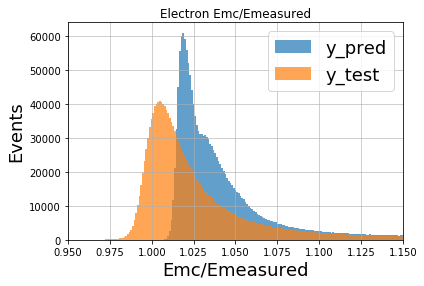

In [16]:
plt.title("Electron Emc/Emeasured")
plot_name = 'results.pdf'
# add extra 0 if want a finer binning.
bin_size = 0.001; 

bins = 20000 
min_edge = 0.95; max_edge = 1.15
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
bins= bin_list

plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

plt.xlim((min_edge, max_edge))  # adjust the top leaving bottom unchanged

# The convention is that 0th element is the main estimate, and 1th and 2nd elements in 
# the y_pred array(array of 3 elements) are 25 and 75% quantiles correspondingly.

# To plot the estimate, use '0:1', for 25% quantile '1:2', for 75% quantile use '2:3'.
plt.hist(y_pred[:,0:1], bins, alpha=0.7, label='y_pred')
plt.hist(y_test, bins, alpha=0.7, label='y_test')

plt.rcParams["figure.figsize"] = [15,15]
plt.legend(prop={'size': 18}, loc='upper right')
#plot.legend(loc=2, prop={'size': 6})
plt.xlabel("Emc/Emeasured", fontsize=18)
plt.ylabel('Events', fontsize=18)#plt.show()

# May need to uncomment lines below if the picture is small.

#fig = plt.figure( figsize=(20, 20))
#fig.set_figheight(20)
#fig.set_figwidth(30)



plt.savefig(plot_name, dpi=400)

### Plot the estimate and quantiles.

/usr/local/bin/start_ipykernel.py:16: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


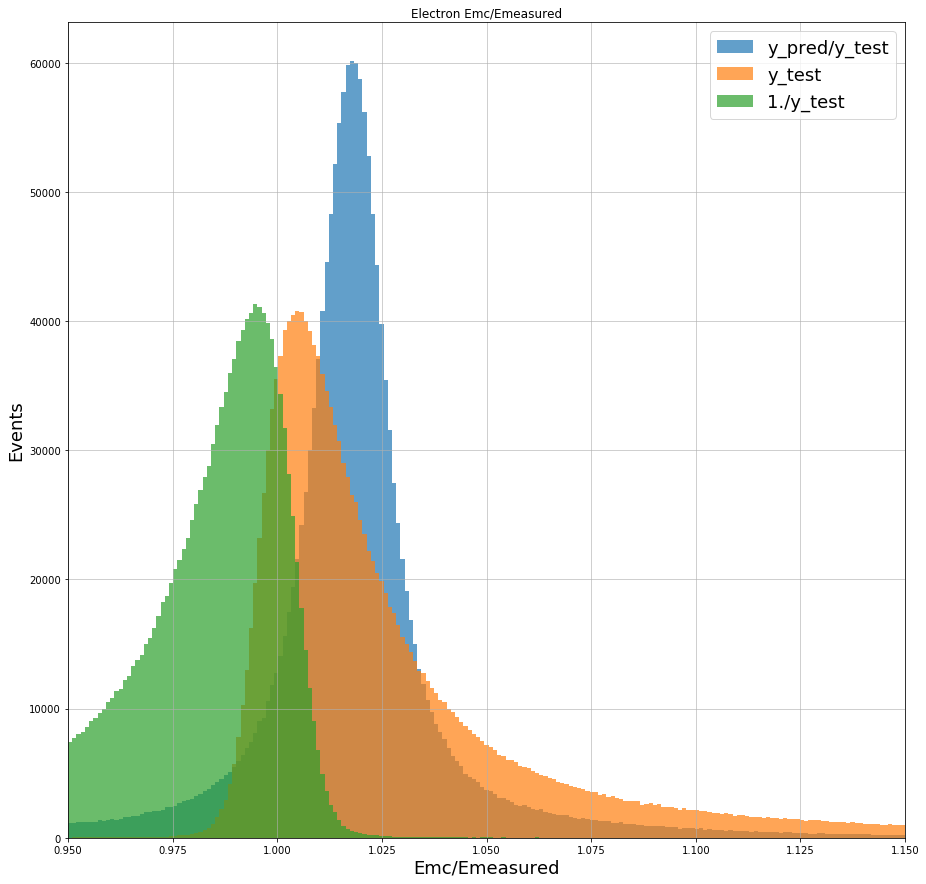

In [19]:
plt.title("Electron Emc/Emeasured")
plot_name = 'Estimate_and_quantiles.pdf'
# add extra 0 if want a finer binning.
bin_size = 0.001; 

bins = 20000 
min_edge = 0.95; max_edge = 1.15
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
bins= bin_list

plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

plt.xlim((min_edge, max_edge))  # adjust the top leaving bottom unchanged

# The convention is that 0th element is the main estimate, and 1th and 2nd elements in 
# the y_pred array(array of 3 elements) are 25 and 75% quantiles correspondingly.

# To plot the estimate, use '0:1', for 25% quantile '1:2', for 75% quantile use '2:3'.
plt.hist(y_pred[:,0:1], bins, alpha=0.7, label='y_pred')
plt.hist(y_pred[:,1:2], bins, alpha=0.7, label='y_pred_25')
plt.hist(y_pred[:,2:3], bins, alpha=0.7, label='y_pred_75')

plt.rcParams["figure.figsize"] = [15,15]
plt.legend(prop={'size': 18}, loc='upper right')
#plot.legend(loc=2, prop={'size': 6})
plt.xlabel("Emc/Emeasured", fontsize=18)
plt.ylabel('Events', fontsize=18)#plt.show()

# May need to uncomment lines below if the picture is small.

#fig = plt.figure( figsize=(20, 20))
#fig.set_figheight(20)
#fig.set_figwidth(30)



plt.savefig(plot_name, dpi=400)